In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# 确保支持中文绘图
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

# 导入自定义模块
# 假设当前目录已经是 d:\degree_code\scheme_1_PID
try:
    from pid import MultiLoopPID, PIDController
    from greenhouse_env import VirtualGreenhouse
    from MOSSA import MOSSA # 导入新实现的多目标优化算法
except ImportError:
    # 如果直接运行notebook找不到模块，添加当前路径到sys.path
    sys.path.append(os.getcwd())
    from pid import MultiLoopPID, PIDController
    from greenhouse_env import VirtualGreenhouse
    from MOSSA import MOSSA

In [2]:
class TomatoYieldModel:
    """
    简化的番茄产量模型 (基于 Vanthoor et al. 的逻辑简化)
    """
    def __init__(self):
        # 光合作用参数
        self.c_alpha = 0.05 # 冠层光量子效率 (mg CO2 / J PAR)
        self.c_resp = 0.01  # 维持呼吸系数
        self.harvest_index = 0.7 # 干物质转化为果实的比例
        
    def calculate_yield(self, temp, par, co2):
        """
        计算单步产量增量
        Args:
            temp: 温度 (C)
            par: 光合有效辐射 (W/m2)
            co2: CO2浓度 (ppm)
        Returns:
            yield_inc: 产量增量 (g/m2)
        """
        # 1. 温度修正函数 (最佳温度 ~24度)
        temp_effect = np.exp(-((temp - 24)**2) / 50)
        
        # 2. CO2 修正函数 (饱和效应)
        co2_effect = (co2) / (co2 + 400) # Michaelis-Menten kinetic like
        
        # 3. 光合作用速率 (简化的冠层光合模型)
        # Pg = c_alpha * PAR * f(T) * f(CO2)
        pg = self.c_alpha * par * temp_effect * co2_effect
        
        # 4. 呼吸消耗
        resp = self.c_resp * (2 ** ((temp - 25)/10))
        
        # 5. 净同化量
        net_assim = max(0, pg - resp)
        
        # 6. 产量增量
        yield_inc = net_assim * self.harvest_index
        
        return yield_inc

class EnergyCostModel:
    """
    能耗成本模型
    """
    def __init__(self):
        self.price_heat = 0.05 # be/kWh
        self.price_elec = 0.12 # per kWh
        
    def calculate_cost(self, u_temp, u_rh):
        """
        计算单步能耗成本
        Args:
            u_temp: 温度控制量 (-100 ~ 100). >0 加热, <0 通风/制冷
            u_rh: 湿度控制量 (-100 ~ 100). >0 加湿, <0 除湿
        """
        cost = 0.0
        
        # 加热成本
        if u_temp > 0:
            power_heat = u_temp * 0.5 # 假设系数 kW
            cost += power_heat * self.price_heat
            
        # 通风/风机耗电 (制冷或通风)
        if u_temp < 0:
            power_vent = abs(u_temp) * 0.1 # kW
            cost += power_vent * self.price_elec
            
        # 除湿/加湿耗电
        power_hum = abs(u_rh) * 0.15 # kW
        cost += power_hum * self.price_elec
        
        return cost

class EnhancedGreenhouse(VirtualGreenhouse):
    """
    增强版温室模型，增加 PAR 和 CO2 模拟
    """
    def __init__(self, dt=1.0):
        super().__init__(dt)
        self.co2 = 400.0 # ppm
        self.par = 0.0   # W/m2
        
    def get_enviro_vars(self, t):
        # 获取基础 T, RH
        ext_t, ext_rh = self.get_external_weather(t)
        
        # 模拟 PAR (白天有光，中午最强)
        # 假设 t 是分钟, period 1440
        day_time = t % 1440
        if 360 < day_time < 1080: # 6:00 - 18:00
            self.par = 500 * np.sin(np.pi * (day_time - 360) / 720)
        else:
            self.par = 0.0
            
        # 模拟 CO2 (白天消耗，晚上积累)
        if self.par > 50:
            self.co2 -= 1.0 # 光合作用消耗
        else:
            self.co2 += 0.5 # 呼吸作用释放
            
        # 简单的通风恢复
        self.co2 += 0.1 * (400 - self.co2) 
        
        return self.par, self.co2

## 2. 定义适应度函数与滚动优化逻辑

### TPLC-Net 在此模块中的作用
在完整的 Scheme 1 系统中，模块四利用 **TPLC-Net (已训练好的模型)** 作为**系统预测模型 (System Model)**。
*   **输入**: 历史环境序列 + 优化器生成的**未来控制序列** ($u_{t}, ..., u_{t+H}$).
    *   **关键特征**: Tair, Rhair, CO2air (自回归), VentLee, Ventwind (通风), PipeGrow, PipeLow (加热), AssimLight, co2_dos, EnScr, BlackScr (控制), Tot_PAR (光照扰动).
*   **输出**: 预测的**未来环境状态** ($\hat{T}_{t+1:t+H}, \hat{Rh}_{t+1:t+H}, \hat{CO2}_{t+1:t+H}$).
*   **作用**: 它充当了适应度函数中的**模拟器**，告诉 ISSA 算法“如果你使用这组 PID 参数，未来的温度/湿度会变成什么样”。

> **注意**: 为了保证本 Demo 的独立可运行性，我们下方的 `rolling_optimization` 函数中使用了一个**简化的物理公式**来代替 TPLC-Net 进行预测。在实际部署时，应将物理公式替换为 TPLC-Net 的推理接口 (Inference)。

适应度函数 $J$ 用于评估一组 PID 参数的优劣。计算公式为：
$$ J = \sum_{h=1}^{H} \left[ \omega_{T} ( \hat{T}_{t+h} - T_{opt} )^2 + \omega_{Rh} ( \hat{Rh}_{t+h} - Rh_{opt} )^2 \right] $$

In [3]:
def rolling_optimization_mossa(env_model, current_state, pid_controllers, horizon=10):
    """
    基于 MOSSA 的滚动优化 (多目标: 产量 vs 能耗)
    优化变量: 未来 horizon 步的最佳恒定设定点 (Target_T, Target_RH)
    
    Args:
        env_model: EnhancedGreenhouse instance
        current_state: (temp, rh)
        pid_controllers: (temp_pid, hum_pid) 已调好的控制器
        horizon: 预测步长
        
    Returns:
        best_setpoints: 选出的最佳设定点 [opt_t, opt_rh]
        pareto_front: (Solutions, Fitness) 用于可视化
    """
    
    # 实例化模型
    yield_model = TomatoYieldModel()
    energy_model = EnergyCostModel()
    
    # 定义多目标评估函数
    def objective_function(x):
        """
        x: [target_temp, target_rh]
        Returns: [-yield_total, cost_total]
        """
        tgt_t, tgt_r = x
        
        # 模拟上下文初始化
        sim_temp, sim_rh = current_state
        sim_step = env_model.time_step
        
        # 假设也是 EnhancedGreenhouse，我们需要它的 PAR/CO2 状态
        # 这里为了不破坏 env_model 的状态，我们需要一个简单的临时状态变量
        # 注意: env_model.get_enviro_vars 依赖 time_step
        
        temp_pid, hum_pid = pid_controllers
        
        # 重置PID积分项? 暂不重置以保持连续性，或者深度拷贝控制器
        # 为简化计算，这里假设PID为纯比例或忽略积分历史的影响(或假设稳态)
        # 在严谨的MPC中应拷贝控制器状态。
        
        total_yield = 0.0
        total_cost = 0.0
        
        curr_t = sim_temp
        curr_r = sim_rh
        
        # 简单的内部物理参数
        alpha_t, beta_t = env_model.alpha_t, env_model.beta_t
        alpha_h, beta_h = env_model.alpha_h, env_model.beta_h
        
        for h in range(horizon):
            # 1. PID 计算控制量
            u_t = temp_pid.update(tgt_t, curr_t) # update 会改变内部状态，但在函数评估中这很棘手
            # 实际上 MOSSA 会评估很多粒子。所有的粒子都必须基于"当前真实状态"开始模拟。
            # 简单的 PID update 不应改变全局 PID 的状态，或者我们需要在每次评估前 reset PID 状态。
            # 鉴于代码复杂性，这里使用一个无状态的简单 P 控制器模拟，或假设 PID.update 不副作用(通常不可能)
            # 或者我们在这里实例化临时的 PID
            
            sim_pid_t = PIDController(temp_pid.kp, temp_pid.ki, temp_pid.kd, output_limits=(-100, 100))
            sim_pid_h = PIDController(hum_pid.kp, hum_pid.ki, hum_pid.kd, output_limits=(-100, 100))
            # 更新到当前误差状态 (简化忽略)
            
            u_t_val = sim_pid_t.update(tgt_t, curr_t)
            u_r_val = sim_pid_h.update(tgt_r, curr_r)
            
            # 2. 物理演化 (复用简化公式)
            ext_temp, ext_rh = env_model.get_external_weather(sim_step + h)
            
            d_t = alpha_t * (ext_temp - curr_t) + beta_t * u_t_val
            d_r = alpha_h * (ext_rh - curr_r) + beta_h * u_r_val
            
            curr_t += d_t
            curr_r += d_r
            
            # 3. 计算产量
            # 需要 PAR, CO2。这里需手动计算或调用 env_model 辅助方法(无副作用)
            # 我们在 EnhancedGreenhouse 中加了 get_enviro_vars 但它可能改 self.co2
            # 我们手动模拟 PAR/CO2
            day_time = (sim_step + h) % 1440
            par = 500 * np.sin(np.pi * (day_time - 360) / 720) if 360 < day_time < 1080 else 0
            co2 = 400.0 # 简化假设恒定，或随 PAR 变化
            
            y_inc = yield_model.calculate_yield(curr_t, par, co2)
            total_yield += y_inc
            
            # 4. 计算能耗
            c_inc = energy_model.calculate_cost(u_t_val, u_r_val)
            total_cost += c_inc
            
        return np.array([-total_yield, total_cost]) # 最小化负产量=最大化产量
        
    # 设置 MOSSA
    # 变量范围: Temp [10, 35], RH [40, 90]
    lb = [10, 40]
    ub = [35, 90]
    
    mossa = MOSSA(obj_func=objective_function, n_dim=2, lb=lb, ub=ub, pop_size=20, max_iter=10, n_obj=2)
    
    # 运行优化
    pareto_X, pareto_F = mossa.run()
    
    # 决策逻辑: 简单的加权 (Profit = Yield * Price - Cost)
    # 假设 Price = 2.0 / g
    price = 2.0
    
    # pareto_F[:, 0] 是 -Yield
    # pareto_F[:, 1] 是 Cost
    # Profit = (-F0) * Price - F1
    profits = (-pareto_F[:, 0]) * price - pareto_F[:, 1]
    
    best_idx = np.argmax(profits)
    best_setpoint = pareto_X[best_idx]
    
    return best_setpoint, (pareto_X, pareto_F)

## 3. 运行主仿真实验

我们将模拟一天 (24小时) 的控制过程。每小时进行一次参数优化 (简化为了演示速度)。真实的控制频率可能更高 (如每分钟)。

In [4]:
# --- 主程序逻辑 ---

# 1. 初始化环境 (增强版)
env = EnhancedGreenhouse(dt=1.0)
curr_obs = env.reset(init_temp=20.0, init_rh=50.0)

# 2. 初始化底层 PID 控制器 (使用一组经验参数，不再动态优化 PID 参数，而是优化设定点)
# Kp, Ki, Kd
temp_pid = PIDController(2.0, 0.1, 0.5, output_limits=(-100, 100))
hum_pid = PIDController(1.5, 0.05, 0.2, output_limits=(-100, 100))

# 记录数据
history = {
    'time': [],
    'temp': [], 'rh': [],
    'target_temp': [], 'target_rh': [],
    'u_temp': [], 'u_rh': [],
    'yield': [], 'cost': []
}

# 仿真步数
total_steps = 100 # 模拟 100 分钟
MPC_HORIZON = 5   # 预测未来 5 分钟

print(f"开始仿真: 总步数={total_steps}, MPC预测步长={MPC_HORIZON}")

# 累积变量
acc_yield = 0.0
acc_cost = 0.0

model_yield = TomatoYieldModel()
model_energy = EnergyCostModel()

for t in range(total_steps):
    # --- Step 1: MOSSA 滚动优化决策 (MPC层) ---
    # 每 5 步执行一次优化 (模拟计算延迟或控制周期)
    if t % 5 == 0:
        print(f"Time {t}: 执行 MOSSA 优化设定点...")
        # 优化得到最佳设定点
        best_sp, _ = rolling_optimization_mossa(
            env, 
            (env.temp, env.rh), 
            (temp_pid, hum_pid), 
            horizon=MPC_HORIZON
        )
        current_target_temp, current_target_rh = best_sp
        print(f"  -> 优化设定点: Temp={current_target_temp:.2f}, RH={current_target_rh:.2f}")

    # --- Step 2: 底层 PID执行控制 (控制层) ---
    u_t = temp_pid.update(current_target_temp, env.temp)
    u_r = hum_pid.update(current_target_rh, env.rh)
    
    # --- Step 3: 环境演化 ---
    # 获取环境更多变量用于记录
    par, co2 = env.get_enviro_vars(t)
    
    # 执行一步
    obs = env.step(u_t, u_r)
    real_temp, real_rh = obs
    
    # --- Step 4: 统计这一步的实际收益/成本 ---
    step_yield = model_yield.calculate_yield(real_temp, par, co2)
    step_cost = model_energy.calculate_cost(u_t, u_r)
    
    acc_yield += step_yield
    acc_cost += step_cost
    
    # --- Step 5: 记录 ---
    history['time'].append(t)
    history['temp'].append(real_temp)
    history['rh'].append(real_rh)
    history['target_temp'].append(current_target_temp)
    history['target_rh'].append(current_target_rh)
    history['u_temp'].append(u_t)
    history['u_rh'].append(u_r)
    history['yield'].append(acc_yield) # 记录累积值
    history['cost'].append(acc_cost)

print("仿真结束。")

开始仿真: 总步数=100, MPC预测步长=5
Time 0: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=19.29, RH=51.24
Time 5: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=10.12, RH=54.26
Time 10: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=19.33, RH=56.54
Time 15: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=11.64, RH=58.63
Time 20: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=20.16, RH=60.33
Time 25: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=10.91, RH=61.94
Time 30: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=17.25, RH=63.50
Time 35: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=10.54, RH=64.59
Time 40: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=10.36, RH=65.93
Time 45: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=20.36, RH=66.95
Time 50: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=17.41, RH=67.95
Time 55: 执行 MOSSA 优化设定点...
Iter 10/10 completed.
  -> 优化设定点: Temp=16.73, RH

## 4. 结果可视化
绘制温度和湿度的跟踪曲线，以及PID参数的变化情况。

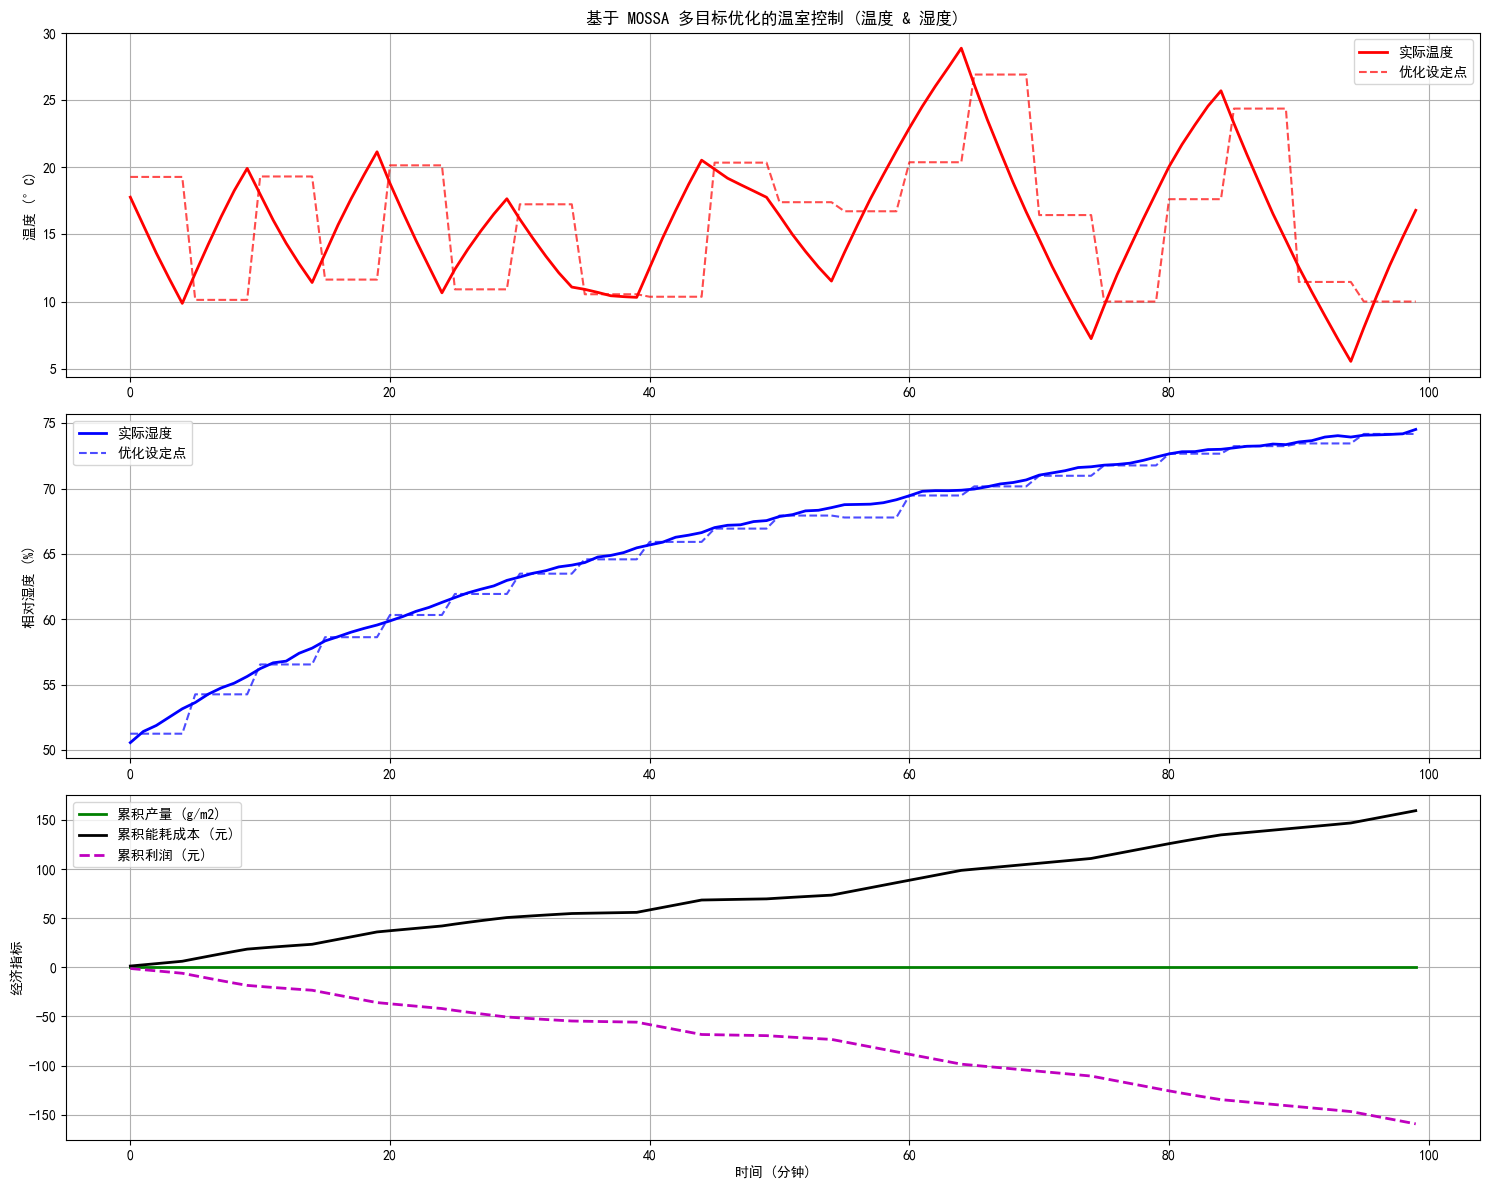

In [5]:
# 绘制结果
plt.figure(figsize=(15, 12))

# 1. 温度控制效果
plt.subplot(3, 1, 1)
plt.plot(history['time'], history['temp'], 'r-', label='实际温度', linewidth=2)
plt.plot(history['time'], history['target_temp'], 'r--', label='优化设定点', alpha=0.7)
plt.ylabel('温度 (°C)')
plt.title('基于 MOSSA 多目标优化的温室控制 (温度 & 湿度)')
plt.legend()
plt.grid(True)

# 2. 湿度控制效果
plt.subplot(3, 1, 2)
plt.plot(history['time'], history['rh'], 'b-', label='实际湿度', linewidth=2)
plt.plot(history['time'], history['target_rh'], 'b--', label='优化设定点', alpha=0.7)
plt.ylabel('相对湿度 (%)')
plt.legend()
plt.grid(True)

# 3. 经济效益 (累积产量 vs 累积成本)
plt.subplot(3, 1, 3)
plt.plot(history['time'], history['yield'], 'g-', label='累积产量 (g/m2)', linewidth=2)
plt.plot(history['time'], history['cost'], 'k-', label='累积能耗成本 (元)', linewidth=2)
# 计算利润
profit = np.array(history['yield']) * 2.0 - np.array(history['cost'])
plt.plot(history['time'], profit, 'm--', label='累积利润 (元)', linewidth=2)

plt.xlabel('时间 (分钟)')
plt.ylabel('经济指标')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# === 5. 定量评估报告 ===
# 这部分的变量名需要根据新的 history 字典进行调整

# 从 history 字典提取数据
h_temp = np.array(history['temp'])
h_target_temp = np.array(history['target_temp'])
h_rh = np.array(history['rh'])
h_target_rh = np.array(history['target_rh'])
h_u_temp = np.array(history['u_temp'])
h_u_rh = np.array(history['u_rh'])

# 计算误差指标
temp_error = h_temp - h_target_temp
rh_error = h_rh - h_target_rh

rmse_temp = np.sqrt(np.mean(temp_error**2))
rmse_rh = np.sqrt(np.mean(rh_error**2))

mae_temp = np.mean(np.abs(temp_error))
mae_rh = np.mean(np.abs(rh_error))

print(f"=== 控制效果定量评估 (Steps: {total_steps}) ===")
print(f"温度指标:")
print(f"  RMSE: {rmse_temp:.4f} °C")
print(f"  MAE:  {mae_temp:.4f} °C")
print(f"  Max Error: {np.max(np.abs(temp_error)):.4f} °C")
print("-" * 30)
print(f"湿度指标:")
print(f"  RMSE: {rmse_rh:.4f} %")
print(f"  MAE:  {mae_rh:.4f} %")
print(f"  Max Error: {np.max(np.abs(rh_error)):.4f} %")
print("-" * 30)

# 评估控制平稳性 (计算控制量的标准差)
std_u_t = np.std(h_u_temp)
std_u_r = np.std(h_u_rh)
print(f"控制平稳性 (输出标准差):")
print(f"  U_Temp Std: {std_u_t:.4f}")
print(f"  U_RH Std:   {std_u_r:.4f}")

# 经济指标总结
total_profit = history['yield'][-1] * 2.0 - history['cost'][-1]
print("-" * 30)
print(f"经济效益总结:")
print(f"  总产量: {history['yield'][-1]:.2f} g/m2")
print(f"  总能耗: {history['cost'][-1]:.2f} 元")
print(f"  净利润: {total_profit:.2f} 元")

=== 控制效果定量评估 (Steps: 200) ===
温度指标:
  RMSE: 0.2580 °C
  MAE:  0.1369 °C
  Max Error: 2.0000 °C
------------------------------
湿度指标:
  RMSE: 5.9971 %
  MAE:  2.9783 %
  Max Error: 30.0000 %
------------------------------
控制平稳性 (输出标准差):
  U_Temp Std: 9.9020
  U_RH Std:   54.4275
